## Vulnerabilidad

In [ ]:
# import villa del rosario boundaries
# create bounding box
# use this to spatially query the census tract geoms in AWS
# pull in the index of material privation from AWS, calculating a poverty rate (fraction of total hogares)
# map at tract level
# maybe rank? or jsut score 0 to 1, actually, instead of 0 to 100

# then we will be able to simply report:
# - total pop exposed to each hazard level
# - total pop with certain poverty level exposed to each hazard level

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
from io import BytesIO
from owslib.wfs import WebFeatureService

import contextily as ctx
from shapely.geometry import box


USE_CRS = "EPSG:5347"  # posgar para esperanza
WEB_MERCATOR_CRS = "EPSG:3857"

DEFAULT_FIGSIZE = (12, 10)
MAP_PADDING = 500
PLASMA_CMAP = plt.cm.plasma

In [2]:
def setup_base_map(
    figsize=None, bounds=None, boundary_gdf=None, padding_x=None, padding_y=None
):
    """Create figure and set up basic map boundaries with padding."""
    if figsize is None:
        figsize = DEFAULT_FIGSIZE
    if padding_x is None:
        padding_x = MAP_PADDING
    if padding_y is None:
        padding_y = MAP_PADDING

    if bounds is None and boundary_gdf is not None:
        bounds = boundary_gdf.total_bounds

    # Convert bounds to Web Mercator for basemap compatibility
    if bounds is not None:
        # Create a temporary GeoDataFrame with the bounds to reproject
        temp_bounds = gpd.GeoDataFrame(
            geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])], crs=USE_CRS
        )
        bounds_3857 = temp_bounds.to_crs(WEB_MERCATOR_CRS).total_bounds
    else:
        bounds_3857 = bounds

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds_3857[0] - padding_x, bounds_3857[2] + padding_x)
    ax.set_ylim(bounds_3857[1] - padding_y, bounds_3857[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""

    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )

    return ax


def add_north_arrow(ax, x=0.95, y=0.05, arrow_length=0.04):
    """Add a north arrow to the map."""
    ax.annotate(
        "N",
        xy=(x, y),
        xytext=(x, y - arrow_length),
        arrowprops=dict(facecolor="black", width=3, headwidth=10),
        ha="center",
        va="center",
        fontsize=14,
        xycoords=ax.transAxes,
    )


def add_boundary_outline(ax, boundary_gdf, crs="EPSG:3857"):
    """Add the outline of a boundary geodataframe to a map."""
    boundary_3857 = boundary_gdf.to_crs(crs)
    boundary_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor="black",
        linewidth=0.5,
        linestyle="--",
        legend=False,
        zorder=5,
    )


def create_consistent_map(title, boundary_gdf, bounds=None):
    """Create a map with consistent styling and basemap."""
    fig, ax = setup_base_map(bounds=bounds, boundary_gdf=boundary_gdf)

    add_basemap(ax)

    add_north_arrow(ax)

    add_boundary_outline(ax, boundary_gdf)

    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)

    ax.set_axis_off()

    return fig, ax


def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

munis = wfs_to_gdf(wfs_url=base_url, layer_name="ign:municipio", srs="EPSG:4326")

In [59]:
aoi = munis[(munis["nam"] == "Villa del Rosario") & (munis["gid"] == 2960)]
aoi = aoi.to_crs(USE_CRS)

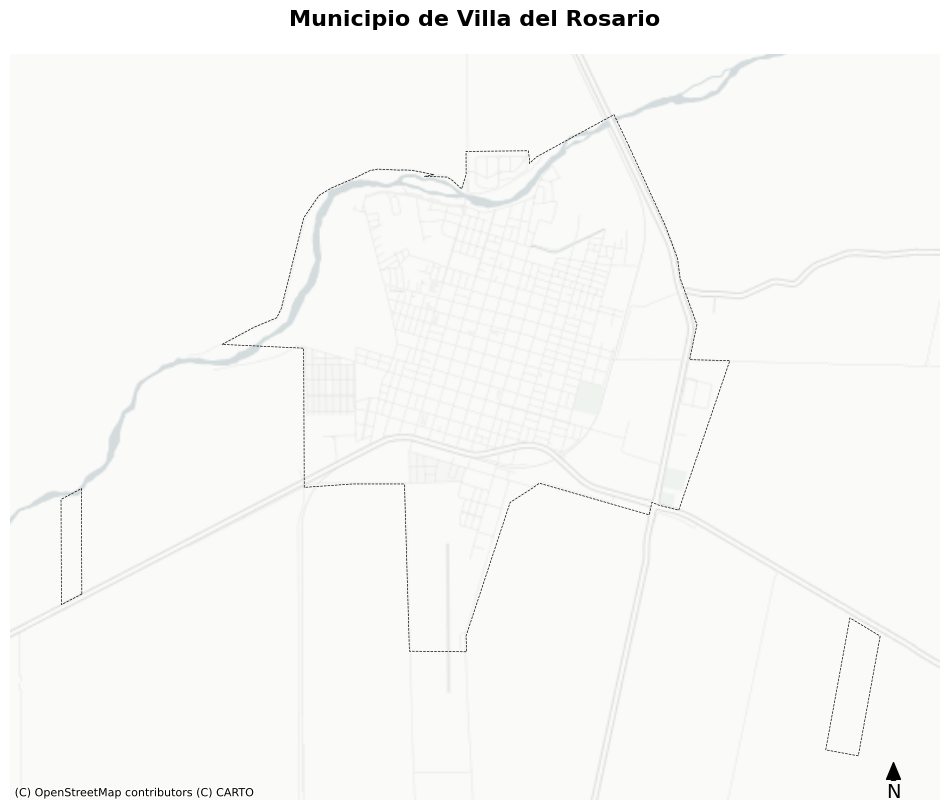

In [60]:
fig, ax = create_consistent_map("Municipio de Villa del Rosario", aoi)

aoi_3857 = aoi.to_crs(WEB_MERCATOR_CRS)


plt.show()

In [ ]:
# import villa del rosario boundaries
# create bounding box
# use this to spatially query the census tract geoms in AWS
# pull in the index of material privation from AWS, calculating a poverty rate (fraction of total hogares)
# map at tract level
# maybe rank? or jsut score 0 to 1, actually, instead of 0 to 100

# then we will be able to simply report:
# - total pop exposed to each hazard level
# - total pop with certain poverty level exposed to each hazard level

In [93]:
import duckdb
import pandas as pd
import geopandas as gpd

# Setup DuckDB and query
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_region='us-east-2'",  # Note: different region for your data
]:
    con.execute(cmd)

temp_file = "privacion_data.parquet"

WGS84_CRS = "EPSG:4326"

bounds = aoi.to_crs(WGS84_CRS).total_bounds

query = f"""
COPY (
    WITH privacion_data AS (
        SELECT 
            id_geo,
            SUM(CASE WHEN valor_categoria IN ('2', '3', '4') THEN conteo ELSE 0 END) AS hogares_con_privacion,
            SUM(conteo) AS total_hogares,
            ROUND((hogares_con_privacion * 100.0) / total_hogares, 2) AS porcentaje_privacion
        FROM 's3://arg-fulbright-data/censo-argentino-2022/censo-2022-largo.parquet'
        WHERE codigo_variable = 'HOGAR_IPMH'
        GROUP BY id_geo
        HAVING total_hogares > 0
    )
    SELECT 
        g.cod_2022,
        g.prov,
        g.depto, 
        g.pob_tot_p,
        g.geometry,
        p.hogares_con_privacion,
        p.total_hogares,
        p.porcentaje_privacion
    FROM 's3://arg-fulbright-data/censo-argentino-2022/radios-2022.parquet' g
    JOIN privacion_data p ON g.cod_2022 = p.id_geo
    WHERE ST_XMax(g.geometry) >= {bounds[0]} 
      AND ST_XMin(g.geometry) <= {bounds[2]}
      AND ST_YMax(g.geometry) >= {bounds[1]} 
      AND ST_YMin(g.geometry) <= {bounds[3]}
) TO '{temp_file}' (FORMAT PARQUET);
"""

con.execute(query)
df = pd.read_parquet(temp_file)
df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="4326")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [94]:
gdf.head()

,COD_2022,PROV,DEPTO,POB_TOT_P,geometry,hogares_con_privacion,total_hogares,porcentaje_privacion
0,141191303,14,119,142,"POLYGON ((-63.52918 -31.54024, -63.52849 -31.5...",12.0,58.0,20.69
1,141190203,14,119,29,"POLYGON ((-63.55791 -31.45791, -63.55668 -31.4...",4.0,11.0,36.36
2,141190806,14,119,615,"POLYGON ((-63.53638 -31.55864, -63.53491 -31.5...",47.0,222.0,21.17
3,141191313,14,119,523,"POLYGON ((-63.53282 -31.55279, -63.5314 -31.55...",49.0,185.0,26.49
4,141191310,14,119,434,"POLYGON ((-63.53878 -31.54707, -63.53803 -31.5...",28.0,181.0,15.47


<Axes: >

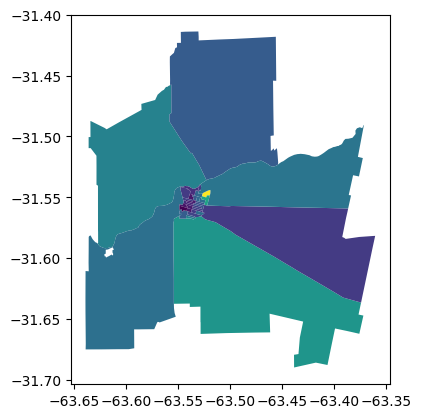

In [98]:
gdf.plot("porcentaje_privacion")

array([[<Axes: title={'center': 'porcentaje_privacion'}>]], dtype=object)

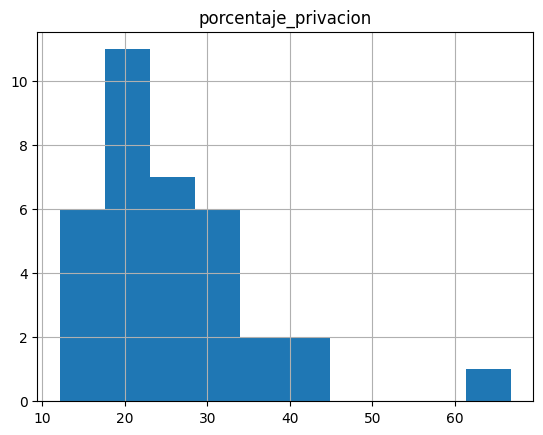

In [97]:
gdf.hist("porcentaje_privacion")

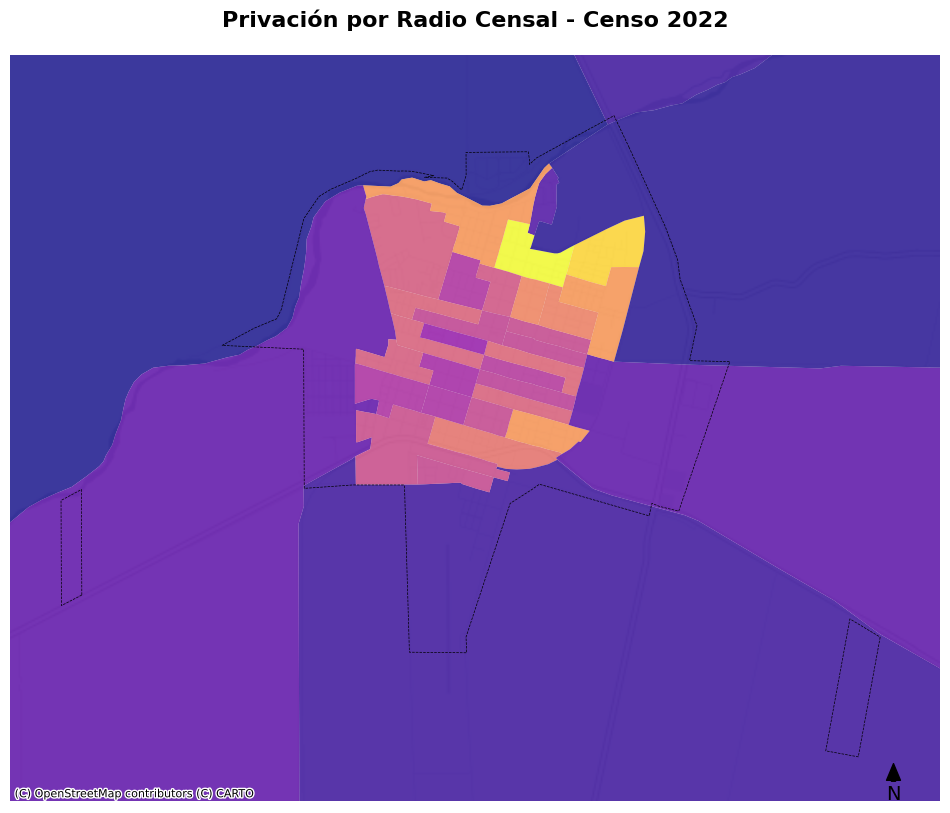

In [100]:
fig, ax = create_consistent_map("Privación por Radio Censal - Censo 2022", aoi)

filtered_gdf_3857 = gdf.to_crs(WEB_MERCATOR_CRS)

filtered_gdf_3857.plot(
    column="POB_TOT_P", ax=ax, cmap=PLASMA_CMAP, legend=False, alpha=0.8, zorder=2
)

plt.title(
    "Privación por Radio Censal - Censo 2022", fontsize=16, fontweight="bold", pad=20
)
plt.show()